In [1]:
#Подключаем все необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu
import My_own_def as md

plt.style.use('ggplot')

In [2]:
df_groups=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-litvintseva-28/Проект_2_groups.csv',sep=';')
df_group_add=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-litvintseva-28/Проект_2_group_add.csv')
df_activ=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-litvintseva-28/Проект_2_active_studs.csv')
df_checks=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-litvintseva-28/Проект_2_checks.csv',sep=';')

In [3]:
'''df_groups=pd.read_csv('Проект_2_groups.csv',sep=';')
df_group_add=pd.read_csv('Проект_2_group_add.csv')
df_activ=pd.read_csv('Проект_2_active_studs.csv')
df_checks=pd.read_csv('Проект_2_checks.csv',sep=';')'''
#Загружаем все файлы

"df_groups=pd.read_csv('Проект_2_groups.csv',sep=';')\ndf_group_add=pd.read_csv('Проект_2_group_add.csv')\ndf_activ=pd.read_csv('Проект_2_active_studs.csv')\ndf_checks=pd.read_csv('Проект_2_checks.csv',sep=';')"

In [4]:
#Сначало разберемся с тем, что от нас требутся и какие данные мы имеем
#Первое действие, понять условие задания и разобраться, какие данные мы будем использовать
#Для начало создадим функцию для анализа данных, или для понимания данных

In [5]:
md.data_info(df_groups)
md.data_info(df_activ)
md.data_info(df_checks)


Проверяем таблицу по столбцу id
74484 Записей
2 Столбцов/а
Нету нуль значений
Нету nan значений

Проверяем таблицу по столбцу student_id
8341 Записей
1 Столбцов/а
Нету нуль значений
Нету nan значений

Проверяем таблицу по столбцу student_id
541 Записей
2 Столбцов/а
Нету нуль значений
Нету nan значений


В данных нету дубликатов по id студента/ записи не повтоятся, нигде нету нуль значений и пропущенных записей

Метрики, которые мы проверяем
1) CR (отношение числа купивших к числу активных)
2) ARPU (средний доход на пользователя)
3) ARPPU (средний доход на платящего пользователя/прибыльность проекта в расчете на одного пользователя)

# Формируем данные для А/В теста

In [6]:
# Отбираем только активных пользователей
full_activ=df_groups.merge(df_activ,left_on='id',right_on='student_id',how='inner')
full_activ.grp.value_counts()

B    6793
A    1535
Name: grp, dtype: int64

In [7]:
# 13 Пользователей не хватает, они были активны, но их нету в df_groups

In [8]:
full_activ_rev=full_activ.merge(df_checks,left_on='id',right_on='student_id',how='left')
# соединили таблицу checks, чтобы узнать на какую сумму закупились активные пользователи в день запуска новой механики

In [9]:
#Видим, что есть nan значения, попробуем их заполнить нулями

In [10]:
full_activ_rev['rev']=full_activ_rev['rev'].fillna (0)
#Заполнили nan нулями

# Тестируем нормальность 

In [11]:
#через scipy
import scipy.stats as ss

df_A=full_activ_rev.query('grp=="A"')
df_B=full_activ_rev.query('grp=="B"')

print(ss.shapiro(df_A.query('rev>0').rev))
print(ss.shapiro(df_B.query('rev>0').rev))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)


In [12]:
# Из теста Шапиро-Уилко мы видим, что наши данные значино отличаются от нормального распределения (pvalue<0.05)

In [13]:
print(ss.normaltest(df_A.query('rev>0').rev))
print(ss.normaltest(df_B.query('rev>0').rev))

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)
NormaltestResult(statistic=7.022269699078301, pvalue=0.029863005181946005)


In [14]:
# Результат тот же самый

# H0: ARPU,ARPPU у обеих выборок одинаковый (только активные)

In [15]:
test=df_B.query('rev>0')['rev']
control=df_A.query('rev>0')['rev']
test_nul=df_B['rev']
control_nul=df_A['rev']
# A/B testing from Bootstrap

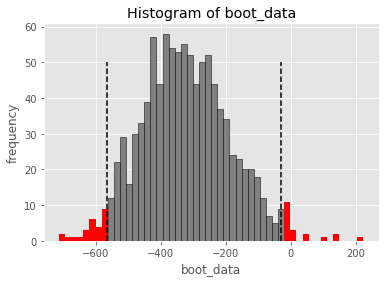

In [16]:
boot_strap=md.get_bootstrap(control,test)

In [17]:
print('p_value =',round(boot_strap['p_value'],4))
round(boot_strap['quants'],2)

p_value = 0.0177


,0
0.025,-565.66
0.975,-30.23


Доверительный интервал не включает ноль, что позоволяет нам откланить нулевую гипотезу (выборки различаются). Это учитывая только пользователей с доходом. То есть ARPPU у активных пользоватлей различается

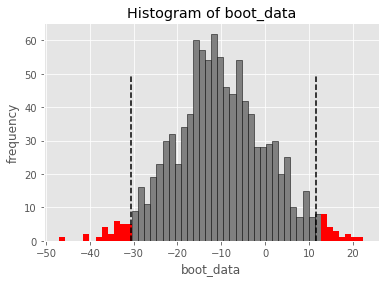

In [18]:
boot_strap=md.get_bootstrap(control_nul,test_nul)

In [19]:
print('p_value =',round(boot_strap['p_value'],4))
round(boot_strap['quants'],2)

p_value = 0.3372


,0
0.025,-30.55
0.975,11.66


HO не отклоняется для ARPU, то есть ARPU не различается

Если только ARPPU различается, выясним в какой группе он больше

# Дисперсионный анализ

Цель: Выяснить зависимость статуса "активный" от суммы дохода в разных группах.

In [20]:
# Для этого анализа дисперсии выборок должны быть примерно равны

In [21]:
group1=df_A.query('rev>0').rev
group2=df_B.query('rev>0').rev
ss.levene(group1,group2,center='median')

LeveneResult(statistic=3.0558643506726035, pvalue=0.08123509393501775)

In [22]:
ss.levene(group1,group2,center='mean')

LeveneResult(statistic=0.3534952458056402, pvalue=0.5524868375224445)

В обоих методах p-значение составляет больше 0,05. Это означает, что в обоих случаях мы не смогли бы опровергнуть нулевую гипотезу. Это означает, что у нас нет достаточных доказательств того, что различия в доходе между двумя механиками значительно различаются.

In [23]:
#Другими словами, группы имеют равные дисперсии

In [24]:
all_dfd=df_groups.merge(df_activ,left_on='id',right_on='student_id',how='left')
data=all_dfd.merge(df_checks,left_on='id',right_on='student_id',how='left')
data.columns = ['id', 'group', 'activ', 'checks','rev']
data[['activ', 'checks','rev']] = data[['activ', 'checks','rev']]. fillna (0)

In [25]:
data

,id,group,activ,checks,rev
0,1489,B,0.0,0.0,0.0
1,1627,A,1627.0,1627.0,990.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0
...,...,...,...,...,...
74479,5692459,B,0.0,0.0,0.0
74480,5692572,B,0.0,0.0,0.0
74481,5692865,B,0.0,0.0,0.0
74482,5693667,B,0.0,0.0,0.0


In [26]:
data['activ']=pd.Series(map(lambda x: 'on' if x>0 else 'off',  data['activ']))
data['checks']=pd.Series(map(lambda x: 1 if x>0 else 0,  data['checks']))

In [27]:
data=data.loc[:,['id','group','activ','checks','rev']]
data.head()

,id,group,activ,checks,rev
0,1489,B,off,0,0.0
1,1627,A,on,1,990.0
2,1768,B,off,0,0.0
3,1783,B,off,0,0.0
4,1794,A,off,0,0.0


In [28]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'rev ~ group + activ'
model = ols(formula, data.query('rev>0')).fit()
aov_table = anova_lm(model, typ=2)

In [29]:
aov_table

,sum_sq,df,F,PR(>F)
group,5.329962e+06,1.0,10.117343,1.553630e-03
activ,2.532333e+07,1.0,48.068781,1.185443e-11
Residual,2.828993e+08,537.0,NaN,NaN


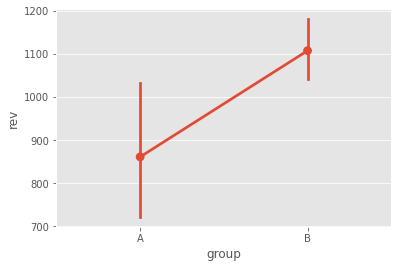

In [30]:
sns.pointplot(x="group",y="rev",data=data.query('rev>0'))

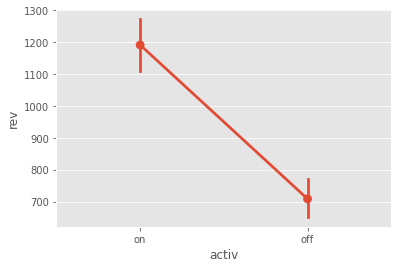

In [31]:
sns.pointplot(x="activ",y="rev",data=data.query('rev>0'))

In [32]:
model_interect = ols("rev ~ group + activ + group:activ", data.query('rev>0')).fit()
anova_lm(model_interect)

,df,sum_sq,mean_sq,F,PR(>F)
group,1.0,5.204301e+06,5.204301e+06,9.903194,1.741627e-03
activ,1.0,2.532333e+07,2.532333e+07,48.187416,1.123521e-11
group:activ,1.0,1.222004e+06,1.222004e+06,2.325334,1.278727e-01
Residual,536.0,2.816773e+08,5.255174e+05,NaN,NaN


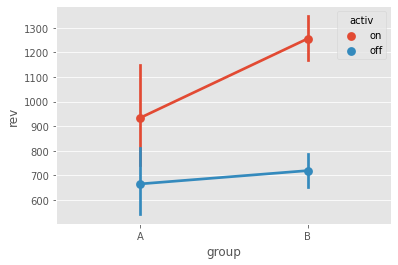

In [33]:
sns.pointplot(x="group",y="rev",hue="activ",data=data.query('rev>0'))

#Значимы эффекты от групп и взаимодействия этих групп
#Больший эффект нам дает статус активности пользователя
#Из графика можно заметить, что доход намного больше от активных пользователей из группы В, а у не активных пользователей в обеих группах почти одинаковый.
#Можно отметить больший доход от активных пользователей группы В, чем от группы А

Сделаем проверку на разброс данных

In [34]:
df_A['rev'].value_counts()

0.0       1457
290.0       25
580.0        6
199.0        5
990.0        5
590.0        5
690.0        4
3660.0       3
840.0        3
1530.0       3
2910.0       2
1140.0       2
1160.0       2
489.0        2
2820.0       2
2890.0       1
2220.0       1
1039.0       1
1980.0       1
870.0        1
2900.0       1
1180.0       1
398.0        1
1830.0       1
Name: rev, dtype: int64

In [35]:
df_B['rev'].value_counts()

0.0000       6480
1900.0000      92
290.0000       45
1900.0001      35
199.0000       27
840.0000       21
990.0000       17
690.0000       13
1140.0000       9
398.0000        6
590.0000        6
1530.0000       5
580.0000        5
870.0000        5
2890.0000       3
2099.0000       3
2910.0000       2
1980.0000       2
3660.0000       2
4650.0000       1
2220.0000       1
1729.0000       1
3040.0000       1
3260.0000       1
1050.0000       1
1968.0000       1
1160.0000       1
796.0000        1
2190.0000       1
1388.0000       1
880.0000        1
597.0000        1
1339.0000       1
489.0000        1
Name: rev, dtype: int64

В группе В есть 92 чека на сумму 1900 и 35 на 1900.0001. Эта сумма есть только в группе В. Можно утверждать, что с новой механикой оплаты пользователи могут совершить покупку на сумму 1900, но почему так мы не знаем (не хватает информации о данных).

# H0: CR не различается (отношение числа купивших к числу активных)

In [36]:
data.head()

,id,group,activ,checks,rev
0,1489,B,off,0,0.0
1,1627,A,on,1,990.0
2,1768,B,off,0,0.0
3,1783,B,off,0,0.0
4,1794,A,off,0,0.0


In [37]:
data.query('activ=="on"').groupby('group').agg(CR=('checks','mean'))

,CR
group,
A,0.050814
B,0.046077


CR у группы А больше чем у группы В, то есть конферсия уменьшилась

Сделам проверку статистической значимости уменьшения CR. И для проверки используем ХИ - квадрат.

# Н0: Различие статистически не значимо.

a=0.05

In [38]:
t1=data.query('activ == "on" and rev>0').groupby('group').count()[["id"]]
t2=data.query('activ == "on" and rev==0').groupby('group').count()[["id"]]

In [39]:
table=pd.concat([t1,t2],axis=1)

In [40]:
table

,id,id
group,,
A,78,1457
B,313,6480


In [41]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(table)
print(p)

0.46803677583199144


p-value<0.05 Подтверждается Н0, различие статичтически незначимо.

# Вывод

После проведения эксперимента мы пришли к выводу, что:

- Средний доход на активного и платящего пользователя увеличился у группы В (полагаем за счет чеков на сумму 1900 )

- А конверсия не изменилась

Главный вопрос - стоит ли запускать новую механику.

Так как конверсия зависит от новой механики оплаты, то делаем вывод. что не стоит.